In [1]:
%cd ../

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_gender


In [2]:
import sys
sys.path.append('../../')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [4]:
# import json
import logging
import pandas as pd
# import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from tqdm.auto import tqdm

# from dltranz.data_load.data_module.cls_data_module import ClsDataModuleTrain

from dltranz.seq_to_target import SequenceToTarget


In [5]:
from dltranz.util import get_cls

In [6]:
from pyhocon import ConfigFactory

In [7]:
import torch

In [8]:
import numpy as np

In [9]:
from torch.utils.data import DataLoader

from dltranz.data_load import padded_collate, IterableChain, IterableAugmentations
from dltranz.data_load.augmentations.build_augmentations import build_augmentations
from dltranz.data_load.data_module.map_augmentation_dataset import MapAugmentationDataset
from dltranz.data_load.iterable_processing.category_size_clip import CategorySizeClip
from dltranz.data_load.iterable_processing.feature_filter import FeatureFilter
from dltranz.data_load.iterable_processing.feature_type_cast import FeatureTypeCast
from dltranz.data_load.iterable_processing.seq_len_filter import SeqLenFilter
from dltranz.data_load.parquet_dataset import ParquetFiles, ParquetDataset


In [10]:
from dltranz.data_load.list_splitter import ListSplitter
from dltranz.data_load.iterable_processing.target_join import TargetJoin
from dltranz.data_load.iterable_processing.id_filter import IdFilter

In [381]:
config_text = """
{
  data_module: {
    setup: {
      dataset_files: {
        train_data_path: "data/train_trx.parquet"
        test_data_path: "data/test_trx.parquet"
      }
      target_file_path: "data/gender_train.csv"
      
      col_id: customer_id
      col_id_dtype: int
      col_target: gender

      substitute_part: 0.5
      valid_part: 0.1
    }

    train: {
        min_seq_len: 0
        augmentations: [
            [RandomSlice, {min_len: 250, max_len: 350, rate_for_min: 0.9}]
            [DropoutTrx, {trx_dropout: 0.01}]
        ]
        num_workers: 16
        batch_size: 32
    }

    valid: {
        augmentations: [
            [SeqLenLimit, {max_seq_len: 1200}]
        ]
        num_workers: 8
        batch_size: 64   # 512
    }
    test: {
        augmentations: [
            [SeqLenLimit, {max_seq_len: 1200}]
        ]
        num_workers: 20
        batch_size: 2000
    }
  }

  seed_everything: 42

  target:
  {
      logger_name: adv_target
      trainer: {
        gpus: 1
        auto_select_gpus: false

        # max_epochs: 50
        max_epochs: 10

        checkpoint_callback: false
        deterministic: True
      }
      params: {
        score_metric: [auroc, accuracy]

        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          hidden_size: 48,
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [BatchNorm1d, {num_features: "{seq_encoder.embedding_size}"}]
            [Linear, {"in_features": "{seq_encoder.embedding_size}", "out_features": 2}]
            [BatchNorm1d, {num_features: 2}]
            [Linear, {"in_features": 2, "out_features": 1}]
            [Sigmoid, {}]
            [Squeeze, {}]
        ]

        train: {
          random_neg: false,
          loss: bce,
          lr: 0.005,
          weight_decay: 0.0,
        },
        lr_scheduler: {
          step_size: 1,
          step_gamma: 0.70
        }
      }
  }
  
  substitute:
  {
      logger_name: adv_substitute
      trainer: {
        gpus: 1
        auto_select_gpus: false

        # max_epochs: 50
        max_epochs: 10

        checkpoint_callback: false
        deterministic: True
      }
      params: {
        score_metric: [auroc, accuracy]

        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          hidden_size: 48,
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [BatchNorm1d, {num_features: "{seq_encoder.embedding_size}"}]
            [Linear, {"in_features": "{seq_encoder.embedding_size}", "out_features": 1}]
            [Sigmoid, {}]
            [Squeeze, {}]
        ]

        train: {
          random_neg: false,
          loss: bce,
          lr: 0.005,
          weight_decay: 0.0,
        },
        lr_scheduler: {
          step_size: 1,
          step_gamma: 0.70
        }
      }
  }
}
"""

In [382]:
conf = ConfigFactory.parse_string(config_text)

In [13]:
if 'seed_everything' in conf:
    pl.seed_everything(conf['seed_everything'])

Global seed set to 42


In [14]:
logger = logging.getLogger(__name__)

In [15]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)-7s %(funcName)-20s   : %(message)s')

In [16]:
class DataSplitter:
    def __init__(self, conf):
        self.setup_conf = conf['setup']
        self.split()
        
    def split(self):
        train_data_files = ParquetFiles(self.setup_conf['dataset_files.train_data_path']).data_files
        test_data_files = ParquetFiles(self.setup_conf['dataset_files.test_data_path']).data_files

        target_subst_spliter = ListSplitter(
            train_data_files, valid_size=self.setup_conf['substitute_part'], seed=42)
        target_splitter = ListSplitter(
            target_subst_spliter.train, valid_size=self.setup_conf['valid_part'], seed=42)
        substitute_splitter = ListSplitter(
            target_subst_spliter.valid, valid_size=self.setup_conf['valid_part'], seed=42)
        
        self.target_train = target_splitter.train
        self.target_valid = target_splitter.valid
        
        self.substitute_train = substitute_splitter.train
        self.substitute_valid = substitute_splitter.valid
        
        self.test = test_data_files
    
    @property
    def target_files(self):
        return self.target_train, self.target_valid
        
    @property
    def substitute_files(self):
        return self.substitute_train, self.substitute_valid
        
    @property
    def test_files(self):
        return self.test,

In [17]:
class AdversarialTrainDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.train_conf = conf['train']
        self.valid_conf = conf['valid']
        
        self.train_files, self.valid_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()
        self.setup_map()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.train_dataset = ParquetDataset(
            self.train_files,
            post_processing=IterableChain(*self.build_iterable_processing('train')),
            shuffle_files=True,
        )
        self.valid_dataset = ParquetDataset(
            self.valid_files,
            post_processing=IterableChain(*self.build_iterable_processing('valid')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        if part == 'train':
            yield SeqLenFilter(min_seq_len=self.train_conf['min_seq_len'])
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)

    def build_augmentations(self, part):
        if part == 'train':
            return build_augmentations(self.train_conf['augmentations'])
        elif part == 'valid':
            return build_augmentations(self.valid_conf['augmentations'])

    def setup_map(self):
        self.train_dataset = list(tqdm(iter(self.train_dataset)))
        logger.info(f'Loaded {len(self.train_dataset)} for train model')
        self.valid_dataset = list(tqdm(iter(self.valid_dataset)))
        logger.info(f'Loaded {len(self.valid_dataset)} for valid model')

        self.train_dataset = MapAugmentationDataset(
            base_dataset=self.train_dataset,
            a_chain=self.build_augmentations('train'),
        )
        self.valid_dataset = MapAugmentationDataset(
            base_dataset=self.valid_dataset,
            a_chain=self.build_augmentations('valid'),
        )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            collate_fn=padded_collate,
            shuffle=True,
            num_workers=self.train_conf['num_workers'],
            batch_size=self.train_conf['batch_size'],
            drop_last=self.train_conf.get('drop_last', False)
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid_dataset,
            collate_fn=padded_collate,
            num_workers=self.valid_conf['num_workers'],
            batch_size=self.valid_conf['batch_size'],
        )

In [49]:
class AdversarialTestDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.test_conf = conf.get('test', conf['valid'])
        
        self.test_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.test_dataset = ParquetDataset(
            self.test_files,
            post_processing=IterableChain(*self.build_iterable_processing('test')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)
        yield IterableAugmentations(self.build_augmentations(part))

    def build_augmentations(self, part):
        return build_augmentations(self.test_conf['augmentations'])

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            collate_fn=padded_collate,
            shuffle=False,
            num_workers=self.test_conf['num_workers'],
            batch_size=self.test_conf['batch_size'],
            drop_last=False,
        )

In [19]:
data_splitter = DataSplitter(conf['data_module'])

In [20]:
l_conf = conf['target']

_target_trainer_params = l_conf['trainer']
if 'logger_name' in l_conf:
    _target_trainer_params['logger'] = TensorBoardLogger(
        save_dir='lightning_logs',
        name=l_conf.get('logger_name'),
    )
_target_trainer_params['callbacks'] = [
    pl.callbacks.EarlyStopping(monitor='val_auroc', mode='max', min_delta=0.0005, patience=2)
]

target_model = SequenceToTarget(l_conf['params'])

target_dm = AdversarialTrainDataModule(conf['data_module'], target_model, *data_splitter.target_files)
target_trainer = pl.Trainer(**_target_trainer_params)
target_trainer.fit(target_model, target_dm)

target_valid_metrics = {name: float(mf.compute().item()) for name, mf in target_model.valid_metrics.items()}
print(', '.join([f'valid_{name}: {v:.4f}' for name, v in target_valid_metrics.items()]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


0it [00:00, ?it/s]

2021-06-02 13:50:09,615 INFO    setup_map              : Loaded 3030 for train model


0it [00:00, ?it/s]

2021-06-02 13:50:09,676 INFO    setup_map              : Loaded 363 for valid model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
2021-06-02 13:50:13,170 INFO    get_lr_scheduler       : StepLR lr_scheduler used

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | BCELoss       | 0     
1 | _seq_encoder  | RnnSeqEncoder | 29.8 K
2 | _head         | Sequential    | 201   
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_auroc: 0.8226, valid_accuracy: 0.7576


In [21]:
l_conf = conf['substitute']

_substitute_trainer_params = l_conf['trainer']
if 'logger_name' in l_conf:
    _substitute_trainer_params['logger'] = TensorBoardLogger(
        save_dir='lightning_logs',
        name=l_conf.get('logger_name'),
    )
_substitute_trainer_params['callbacks'] = [
    pl.callbacks.EarlyStopping(monitor='val_auroc', mode='max', min_delta=0.0005, patience=2)
]
substitute_trainer = pl.Trainer(**_substitute_trainer_params)

substitute_model = SequenceToTarget(l_conf['params'])
substitute_dm = AdversarialTrainDataModule(conf['data_module'], target_model, *data_splitter.substitute_files)
substitute_trainer.fit(substitute_model, substitute_dm)

substitute_valid_metrics = {name: float(mf.compute().item()) for name, mf in substitute_model.valid_metrics.items()}
print(', '.join([f'valid_{name}: {v:.4f}' for name, v in substitute_valid_metrics.items()]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


0it [00:00, ?it/s]

2021-06-02 13:50:48,766 INFO    setup_map              : Loaded 3797 for train model


0it [00:00, ?it/s]

2021-06-02 13:50:48,823 INFO    setup_map              : Loaded 370 for valid model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
2021-06-02 13:50:48,828 INFO    get_lr_scheduler       : StepLR lr_scheduler used

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | BCELoss       | 0     
1 | _seq_encoder  | RnnSeqEncoder | 29.8 K
2 | _head         | Sequential    | 145   
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_auroc: 0.7707, valid_accuracy: 0.7072


In [50]:
test_dm = AdversarialTestDataModule(conf['data_module'], target_model, *data_splitter.test_files)
test_dm.prepare_data()

In [51]:
target_trainer.test(model=target_model, test_dataloaders=test_dm.test_dataloader())
target_test_metrics = {name: float(mf.compute().item()) for name, mf in target_model.test_metrics.items()}
print(', '.join([f'test_{name}: {v:.4f}' for name, v in target_test_metrics.items()]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7595238089561462, 'test_auroc': 0.84697026014328}
--------------------------------------------------------------------------------
test_auroc: 0.8470, test_accuracy: 0.7595


In [52]:
substitute_trainer.test(model=substitute_model, test_dataloaders=test_dm.test_dataloader())
substitute_test_metrics = {name: float(mf.compute().item()) for name, mf in substitute_model.test_metrics.items()}
print(', '.join([f'test_{name}: {v:.4f}' for name, v in substitute_test_metrics.items()]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7559523582458496, 'test_auroc': 0.8462646007537842}
--------------------------------------------------------------------------------
test_auroc: 0.8463, test_accuracy: 0.7560


In [25]:
target_valid_metrics, target_test_metrics, substitute_valid_metrics, substitute_test_metrics

({'auroc': 0.8226419687271118, 'accuracy': 0.7575837969779968},
 {'auroc': 0.84697026014328, 'accuracy': 0.7595238089561462},
 {'auroc': 0.7707414627075195, 'accuracy': 0.7071577906608582},
 {'auroc': 0.8462646007537842, 'accuracy': 0.7559523582458496})

In [53]:
target_emb_model = torch.nn.Sequential(
    target_model._seq_encoder,
    *target_model._head[:-3],
)

In [54]:
from dltranz.train import score_model2

In [55]:
target_embeddings, y = tuple(score_model2(target_emb_model, test_dm.test_dataloader(), {}))

In [56]:
assert target_embeddings.shape[1] == 2

In [57]:
import matplotlib.pyplot as plt

In [58]:
from sklearn.decomposition import PCA

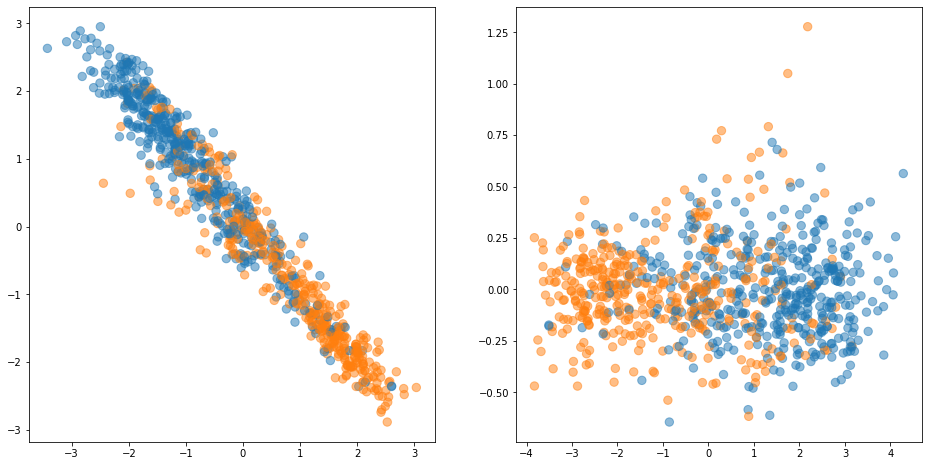

In [59]:
_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(target_embeddings[:, 0], target_embeddings[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.5, s=70)

pca = PCA(2)
pca.fit(target_embeddings)
target_pca = np.dot(target_embeddings, pca.components_.T)
axs[1].scatter(target_pca[:, 0], target_pca[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.5, s=70)

plt.show()

In [318]:
from itertools import islice, product

In [325]:
class GreadyAttacker:
    def __init__(self):
        self._src = None

    def __call__(self, src):
        self._src = src
        return iter(self)

    def __iter__(self):
        for i, rec in enumerate(self._src):
            for t in self.process(i, rec):
                yield t

    def process(self, i, x):
        # original record
        rec, y = x
        yield rec, {'id': i, 'y': y, 'new_mcc': None, 'new_mcc_len': 0}
        
        for mcc_len in [1, 2]:
            new_rec = {}
            for k in rec.keys():
                ['amount', 'event_time', 'mcc_code', ]
                if k in ('tr_type',):
                    new_v = 2
                elif k == 'event_time':
                    new_v = rec[k][-1] + 1
                elif k in ('amount',):
                    new_v = rec[k][-1]
                else:
                    continue
                new_rec[k] = torch.cat([rec[k], torch.tensor([new_v] * mcc_len)])

            for new_mcc in product(*[range(2, 100) for _ in range(mcc_len)]):
                _new_rec = {k: v for k, v in new_rec.items()}
                _new_rec['mcc_code'] = torch.cat([rec['mcc_code'], torch.tensor(new_mcc)])
                yield _new_rec, {'id': i, 'y': y, 'new_mcc': new_mcc, 'new_mcc_len': len(new_mcc)}

In [326]:
class AdversarialAttackDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.test_conf = conf.get('test', conf['valid'])
        
        self.test_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.test_dataset = ParquetDataset(
            self.test_files,
            post_processing=IterableChain(*self.build_iterable_processing('test')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)
        yield IterableAugmentations(self.build_augmentations(part))
        
        yield GreadyAttacker()

    def build_augmentations(self, part):
        return build_augmentations(self.test_conf['augmentations'])

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            collate_fn=padded_collate,
            shuffle=False,
            num_workers=self.test_conf['num_workers'],
            batch_size=self.test_conf['batch_size'],
            drop_last=False,
        )

In [383]:
attack_dm = AdversarialAttackDataModule(conf['data_module'], target_model, *data_splitter.test_files)
attack_dm.prepare_data()

In [486]:
# list(islice(iter(attack_dm.test_dataloader().dataset), 2))

In [385]:
class AttackTestModel(torch.nn.Module):
    def __init__(self, target_model, substitute_model):
        super().__init__()
        
        self.target_emb_model = torch.nn.Sequential(
            target_model._seq_encoder,
            *target_model._head[:-3],
        )
        self.target_head = torch.nn.Sequential(
            *target_model._head[-3:],
        )
        self.substitute_model = substitute_model

    def forward(self, x):
        t_emb = self.target_emb_model(x)
        t_score = self.target_head(t_emb).unsqueeze(-1)
        s_score = self.substitute_model(x).unsqueeze(-1)
        return torch.cat([t_emb, t_score, s_score], dim=1)

attack_test_model = AttackTestModel(target_model, substitute_model)

In [386]:
%%time
ts, original_scores = tuple(score_model2(attack_test_model, attack_dm.test_dataloader(), {'device': 'cuda'}))
for rec, t_x, t_y, t_score, s_score, in zip(original_scores, *ts.T):
    rec['t_x'] = t_x
    rec['t_y'] = t_y
    rec['t_score'] = t_score
    rec['s_score'] = s_score


CPU times: user 8min 44s, sys: 51.3 s, total: 9min 35s
Wall time: 11min 47s


In [387]:
len(original_scores)

8150520

In [388]:
original_scores[95:105]

array([{'id': 0, 'y': 0, 'new_mcc': (96,), 'new_mcc_len': 1, 't_x': -2.7156248, 't_y': 2.2793489, 't_score': 0.01877705, 's_score': 0.01661236},
       {'id': 0, 'y': 0, 'new_mcc': (97,), 'new_mcc_len': 1, 't_x': -2.5424962, 't_y': 2.3108246, 't_score': 0.02056747, 's_score': 0.01669599},
       {'id': 0, 'y': 0, 'new_mcc': (98,), 'new_mcc_len': 1, 't_x': -2.815297, 't_y': 2.2379942, 't_score': 0.018170796, 's_score': 0.015627079},
       {'id': 0, 'y': 0, 'new_mcc': (99,), 'new_mcc_len': 1, 't_x': -2.5431442, 't_y': 2.1993198, 't_score': 0.02258778, 's_score': 0.016841661},
       {'id': 0, 'y': 0, 'new_mcc': (2, 2), 'new_mcc_len': 2, 't_x': -2.677503, 't_y': 2.2645135, 't_score': 0.019513797, 's_score': 0.021371566},
       {'id': 0, 'y': 0, 'new_mcc': (2, 3), 'new_mcc_len': 2, 't_x': -2.4493902, 't_y': 2.2255452, 't_score': 0.023542775, 's_score': 0.019474063},
       {'id': 0, 'y': 0, 'new_mcc': (2, 4), 'new_mcc_len': 2, 't_x': -2.6836743, 't_y': 2.4311244, 't_score': 0.01687392, '

In [389]:
# check accuracy
np.mean([(rec['t_score'] > 0.5) == rec['y'] for rec in original_scores if rec['new_mcc'] is None])

0.7595238095238095

In [390]:
# check accuracy
np.mean([(rec['s_score'] > 0.5) == rec['y'] for rec in original_scores if rec['new_mcc'] is None])

0.7559523809523809

In [391]:
df_test_all = pd.DataFrame(original_scores.tolist())
df_test_orig = df_test_all[lambda x: x['new_mcc'].isna()][['id', 's_score', 't_score', 't_x', 't_y', 'y']] \
    .rename(columns={'s_score': 's_score_orig', 't_score': 't_score_orig', 't_x': 't_x_orig', 't_y': 't_y_orig'})

df_test = pd.merge(
    df_test_all[lambda x: ~x['new_mcc'].isna()],
    df_test_orig.drop(columns='y'),
    on='id',
).assign(s_p_drop=lambda x: x['s_score_orig'] - x['s_score']) \
.assign(t_p_drop=lambda x: x['t_score_orig'] - x['t_score'])

In [392]:
df_test_orig.head()

,id,s_score_orig,t_score_orig,t_x_orig,t_y_orig,y
0,0,0.018739,0.018479,-2.815501,2.217972,0
9703,1,0.829402,0.762054,0.715308,-0.897147,0
19406,2,0.899244,0.632418,0.565019,-0.297807,1
29109,3,0.701576,0.758116,0.897983,-0.725308,0
38812,4,0.913741,0.924194,1.737902,-1.624522,1


In [393]:
df_test_orig.sort_values('s_score_orig').iloc[::80]

,id,s_score_orig,t_score_orig,t_x_orig,t_y_orig,y
970300,100,0.008624,0.032682,-2.175226,2.054842,0
3396050,350,0.027775,0.043025,-1.823120,2.006730,0
3299020,340,0.057216,0.408781,-0.362653,0.013128,0
6995863,721,0.127195,0.057416,-1.994336,1.517165,0
6801803,701,0.238619,0.090108,-1.270186,1.535919,0
359011,37,0.388531,0.048468,-1.798350,1.881970,0
1474856,152,0.506287,0.178910,-1.034310,0.811598,0
7189923,741,0.670863,0.982854,3.035422,-2.375680,1
533665,55,0.847924,0.150895,-1.036304,1.046240,1
1824164,188,0.927139,0.972962,2.339042,-2.395805,1


In [394]:
(df_test_orig['s_score_orig'].ge(0.5) == df_test_orig['y']).mean(), \
(df_test_orig['t_score_orig'].ge(0.5) == df_test_orig['y']).mean()

(0.7559523809523809, 0.7595238095238095)

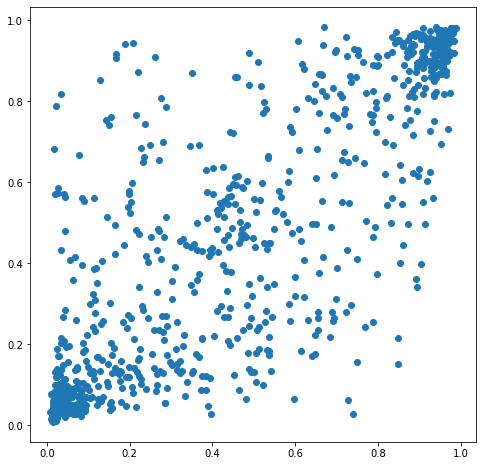

In [395]:
plt.figure(figsize=(8, 8))
plt.scatter(df_test_orig['s_score_orig'], df_test_orig['t_score_orig'])
plt.show()

In [396]:
df_test

,id,y,new_mcc,new_mcc_len,t_x,t_y,t_score,s_score,s_score_orig,t_score_orig,t_x_orig,t_y_orig,s_p_drop,t_p_drop
0,0,0,"(2,)",1,-2.738257,2.236873,0.019167,0.020893,0.018739,0.018479,-2.815501,2.217972,-0.002155,-0.000688
1,0,0,"(3,)",1,-2.578396,2.181667,0.022385,0.017740,0.018739,0.018479,-2.815501,2.217972,0.000999,-0.003906
2,0,0,"(4,)",1,-2.761128,2.410239,0.016292,0.020215,0.018739,0.018479,-2.815501,2.217972,-0.001476,0.002187
3,0,0,"(5,)",1,-2.603251,2.322638,0.019539,0.018154,0.018739,0.018479,-2.815501,2.217972,0.000585,-0.001060
4,0,0,"(6,)",1,-2.669440,2.164258,0.021356,0.021522,0.018739,0.018479,-2.815501,2.217972,-0.002783,-0.002877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8149675,839,0,"(99, 95)",2,0.173746,0.024890,0.498206,0.699384,0.614241,0.456527,-0.230616,-0.106369,-0.085143,-0.041679
8149676,839,0,"(99, 96)",2,-0.325460,-0.011541,0.420206,0.402656,0.614241,0.456527,-0.230616,-0.106369,0.211585,0.036321
8149677,839,0,"(99, 97)",2,0.100953,-0.102566,0.513077,0.722963,0.614241,0.456527,-0.230616,-0.106369,-0.108722,-0.056550
8149678,839,0,"(99, 98)",2,0.113744,0.045125,0.483444,0.675944,0.614241,0.456527,-0.230616,-0.106369,-0.061703,-0.026918


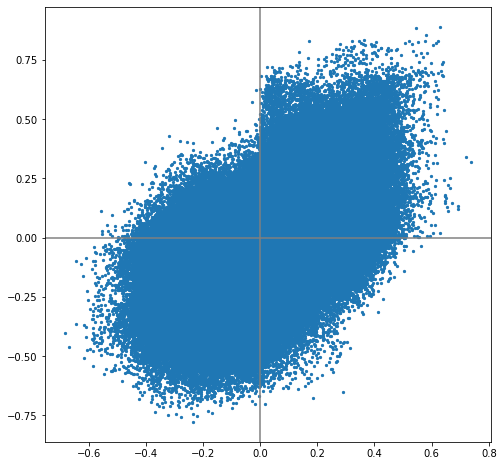

In [397]:
plt.figure(figsize=(8, 8))
plt.scatter(df_test['s_p_drop'], df_test['t_p_drop'], s=5)
plt.axvline(0, color='gray')
plt.axhline(0, color='gray')
plt.show()

In [398]:
from IPython.display import display

In [405]:
for _id in [37]:
    print('id', _id)
    display(df_test[lambda x: x['id'].eq(_id)].sort_values('s_p_drop', ascending=False).iloc[::1000])
    display(df_test[lambda x: x['id'].eq(_id)].sort_values('new_mcc', ascending=True).iloc[::1000])

id 37


,id,y,new_mcc,new_mcc_len,t_x,t_y,t_score,s_score,s_score_orig,t_score_orig,t_x_orig,t_y_orig,s_p_drop,t_p_drop
363527,37,0,"(47, 47)",2,-2.429518,2.291918,0.022563,0.097016,0.388531,0.048468,-1.79835,1.88197,0.291516,0.025904
362245,37,0,"(34, 39)",2,-1.644629,1.963336,0.050174,0.277758,0.388531,0.048468,-1.79835,1.88197,0.110774,-0.001706
364743,37,0,"(59, 87)",2,-1.604105,1.896100,0.054441,0.329660,0.388531,0.048468,-1.79835,1.88197,0.058871,-0.005973
362571,37,0,"(37, 71)",2,-1.686848,1.759716,0.057630,0.368870,0.388531,0.048468,-1.79835,1.88197,0.019662,-0.009162
361414,37,0,"(25, 90)",2,-1.645684,1.636722,0.065394,0.399954,0.388531,0.048468,-1.79835,1.88197,-0.011422,-0.016927
361161,37,0,"(23, 33)",2,-1.607777,1.891585,0.054510,0.427556,0.388531,0.048468,-1.79835,1.88197,-0.039025,-0.006043
362914,37,0,"(41, 22)",2,-1.515364,1.746010,0.065155,0.455274,0.388531,0.048468,-1.79835,1.88197,-0.066743,-0.016687
361337,37,0,"(25, 13)",2,-1.317855,1.609380,0.082507,0.483905,0.388531,0.048468,-1.79835,1.88197,-0.095374,-0.034040
365318,37,0,"(65, 74)",2,-1.697303,1.911796,0.050554,0.518836,0.388531,0.048468,-1.79835,1.88197,-0.130304,-0.002086
368526,37,0,"(98, 48)",2,-1.587176,1.685387,0.065308,0.572190,0.388531,0.048468,-1.79835,1.88197,-0.183658,-0.016840


,id,y,new_mcc,new_mcc_len,t_x,t_y,t_score,s_score,s_score_orig,t_score_orig,t_x_orig,t_y_orig,s_p_drop,t_p_drop
358974,37,0,"(2,)",1,-1.746134,1.788278,0.054161,0.456755,0.388531,0.048468,-1.79835,1.88197,-0.068224,-0.005693
360061,37,0,"(12, 11)",2,-1.429240,1.582791,0.078489,0.482831,0.388531,0.048468,-1.79835,1.88197,-0.094300,-0.030021
361051,37,0,"(22, 21)",2,-1.673747,1.883800,0.052533,0.318430,0.388531,0.048468,-1.79835,1.88197,0.070102,-0.004066
362041,37,0,"(32, 31)",2,-1.218055,1.498240,0.095899,0.414284,0.388531,0.048468,-1.79835,1.88197,-0.025753,-0.047431
363031,37,0,"(42, 41)",2,-1.398624,1.635766,0.076737,0.423155,0.388531,0.048468,-1.79835,1.88197,-0.034624,-0.028269
364021,37,0,"(52, 51)",2,-1.275794,1.489761,0.093099,0.310339,0.388531,0.048468,-1.79835,1.88197,0.078192,-0.044631
365011,37,0,"(62, 61)",2,-1.715415,1.656627,0.061501,0.536816,0.388531,0.048468,-1.79835,1.88197,-0.148284,-0.013034
366001,37,0,"(72, 71)",2,-1.258128,1.349947,0.104942,0.426951,0.388531,0.048468,-1.79835,1.88197,-0.038419,-0.056474
366991,37,0,"(82, 81)",2,-1.597477,1.780625,0.060063,0.360155,0.388531,0.048468,-1.79835,1.88197,0.028377,-0.011595
367981,37,0,"(92, 91)",2,-1.739322,1.776360,0.054934,0.347659,0.388531,0.048468,-1.79835,1.88197,0.040872,-0.006467


In [406]:
df_best_attacks = df_test.groupby('id').apply(lambda x: x.sort_values('s_p_drop', ascending=False).iloc[0])
df_best_attacks

,id,y,new_mcc,new_mcc_len,t_x,t_y,t_score,s_score,s_score_orig,t_score_orig,t_x_orig,t_y_orig,s_p_drop,t_p_drop
id,,,,,,,,,,,,,,
0,0,0,"(47, 47)",2,-2.800935,2.438874,0.015474,0.006984,0.018739,0.018479,-2.815501,2.217972,0.011755,0.003005
1,1,0,"(47, 81)",2,-1.723398,1.229445,0.086104,0.537244,0.829402,0.762054,0.715308,-0.897147,0.292158,0.675950
2,2,1,"(47, 81)",2,0.126850,0.144598,0.464314,0.456319,0.899244,0.632418,0.565019,-0.297807,0.442925,0.168104
3,3,0,"(47, 81)",2,0.453574,-0.179348,0.589792,0.317781,0.701576,0.758116,0.897983,-0.725308,0.383795,0.168324
4,4,1,"(47, 39)",2,1.233882,-1.075071,0.842522,0.794568,0.913741,0.924194,1.737902,-1.624522,0.119172,0.081672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,835,1,"(47, 39)",2,1.358347,-1.333459,0.879360,0.699037,0.873474,0.951396,1.986214,-1.973701,0.174436,0.072037
836,836,0,"(47, 47)",2,-2.124814,1.826225,0.040876,0.050222,0.224780,0.187797,-0.871899,0.873333,0.174558,0.146920
837,837,0,"(24, 47)",2,-1.412810,0.722089,0.153294,0.072043,0.483598,0.603442,0.151566,-0.487809,0.411555,0.450149


In [409]:
# mean p_drop
df_best_attacks['t_p_drop'].mean()

0.1822315004449116

In [410]:
# new accuracy
df_best_attacks.assign(t_new_acc=lambda x: x['t_score'].ge(0.5) == x['y'])['t_new_acc'].mean()

0.7107142857142857

In [413]:
# original confusion matrix
df_best_attacks \
    .assign(t_pred=lambda x: x['t_score_orig'].ge(0.5).astype(int)).pivot_table(
        index='t_pred', columns='y', values='id', aggfunc=len,
)

y,0,1
t_pred,,
0,359,115
1,87,279


In [414]:
# new confusion matrix
df_best_attacks \
    .assign(t_pred=lambda x: x['t_score'].ge(0.5).astype(int)).pivot_table(
        index='t_pred', columns='y', values='id', aggfunc=len,
)

y,0,1
t_pred,,
0,415,212
1,31,182


In [415]:
# top attack mcc
df_best_attacks['new_mcc'].value_counts()

(47, 47)    488
(47, 16)     97
(47, 81)     76
(24, 47)     54
(47, 39)     40
(66, 47)     29
(39, 47)     13
(47, 66)     13
(16, 47)      9
(47, 24)      7
(56, 47)      6
(47, 52)      4
(47, 56)      1
(38, 47)      1
(66, 81)      1
(52, 47)      1
Name: new_mcc, dtype: int64

# Ищем примеры

Подбираем разные примеры:
- разные примеры по эффективности атаки (разные по диапазону t_p_drop)
- разные по сложности (по исходной вероятности класса)

In [431]:
for col in ['t_score_orig', 't_p_drop']:
    df_best_attacks[f'{col}_bin'] = pd.cut(
        df_best_attacks[col],
        df_best_attacks[col].quantile([0, 0.25, 0.5, 0.75, 1]).values,
        labels=range(4),
    ).fillna(0)

In [474]:
def plot_example(_id, suptitle):
    _, axs = plt.subplots(1, 3, figsize=(6 * 3, 6))

    for ax in axs:
        ax.scatter(
            df_test_orig['t_x_orig'], 
            df_test_orig['t_y_orig'],
            c=df_test_orig['y'].apply(plt.get_cmap('tab10')), alpha=0.5
        )
        ax.scatter(
            df_test_orig[lambda x: x['id'].eq(_id)]['t_x_orig'], 
            df_test_orig[lambda x: x['id'].eq(_id)]['t_y_orig'],
            c='black', marker='*', s=600,
        )
        ax.scatter(
            df_test_orig[lambda x: x['id'].eq(_id)]['t_x_orig'], 
            df_test_orig[lambda x: x['id'].eq(_id)]['t_y_orig'],
            c='green', marker='*', s=400,
        )

    df = df_test[lambda x: x['id'].eq(_id) & x['new_mcc_len'].eq(2)].sort_values('new_mcc').iloc[[0]]
    axs[0].scatter(df['t_x'], df['t_y'], c='black', marker='*', s=600)
    axs[0].scatter(df['t_x'], df['t_y'], c='red', marker='*', s=400)
    axs[0].set_title(f'Most popular: {df["new_mcc"].values[0]}')

    df = df_test[lambda x: x['id'].eq(_id) & x['new_mcc_len'].eq(2)].sample(n=1)
    axs[1].scatter(df['t_x'], df['t_y'], c='black', marker='*', s=600)
    axs[1].scatter(df['t_x'], df['t_y'], c='red', marker='*', s=400)
    axs[1].set_title(f'Random: {df["new_mcc"].values[0]}')

    df = df_test[lambda x: x['id'].eq(_id) & x['new_mcc_len'].eq(2)].sort_values('s_p_drop', ascending=False).iloc[[0]]
    axs[2].scatter(df['t_x'], df['t_y'], c='black', marker='*', s=600)
    axs[2].scatter(df['t_x'], df['t_y'], c='red', marker='*', s=400)
    axs[2].set_title(f'Most adversarial: {df["new_mcc"].values[0]}')

    plt.suptitle(suptitle)
    plt.show()

In [477]:
df_best_attacks.groupby(['y', 't_score_orig_bin', 't_p_drop_bin']).apply(lambda x: x.sample(n=3)).loc[[1]] \
    [['id', 'y', 'new_mcc', 'new_mcc_len', 's_p_drop', 't_score_orig', 't_score', 't_p_drop']]

id  y   new_mcc  new_mcc_len  s_p_drop  \
y t_score_orig_bin t_p_drop_bin id                                             
1 0                0            62    62  1  (47, 47)            2  0.018452   
                                352  352  1  (47, 47)            2  0.055038   
                                29    29  1  (47, 47)            2  0.011617   
                   1            20    20  1  (47, 47)            2  0.022610   
                                92    92  1  (24, 47)            2  0.061219   
                                56    56  1  (47, 16)            2  0.425252   
  1                0            580  580  1  (47, 47)            2  0.078814   
                                245  245  1  (66, 47)            2  0.177686   
                                98    98  1  (47, 66)            2  0.250572   
                   1            58    58  1  (47, 47)            2  0.314221   
                                394  394  1  (47, 81)            2  0.341074   
                                46    46  1  (47, 16)            2  0.439148   
                   2            421  421  1  (47, 47)            2  0.170281   
                                218  218  1  (47, 47)            2  0.439227   
                                597  597  1  (47, 81)            2  0.283848   
                   3            819  819  1  (47, 47)            2  0.206099   
                                428  428  1  (47, 16)            2  0.396579   
                                613  613  1  (47, 16)            2  0.515681   
  2                1            675  675  1  (47, 39)            2  0.325019   
                                7      7  1  (47, 39)            2  0.212396   
                                90    90  1  (47, 39)            2  0.163436   
                   2            456  456  1  (47, 47)            2  0.370733   
                                379  379  1  (47, 81)            2  0.262410   
                                140  140  1  (47, 81)            2  0.230022   
                   3            465  465  1  (47, 16)            2  0.446899   
                                702  702  1  (47, 47)            2  0.062468   
                                801  801  1  (47, 66)            2  0.325506   
  3                0            377  377  1  (47, 39)            2  0.151181   
                                256  256  1  (47, 39)            2  0.140068   
                                248  248  1  (56, 47)            2  0.476932   
                   1            657  657  1  (47, 81)            2  0.260230   
                                226  226  1  (47, 39)            2  0.116750   
                                106  106  1  (47, 39)            2  0.166792   
                   2            212  212  1  (66, 47)            2  0.116339   
                                559  559  1  (47, 47)            2  0.305480   
                                443  443  1  (47, 39)            2  0.128258   
                   3            143  143  1  (47, 81)            2  0.287329   
                                424  424  1  (47, 47)            2  0.198766   
                                64    64  1  (47, 47)            2  0.354891   

                                     t_score_orig   t_score  t_p_drop  
y t_score_orig_bin t_p_drop_bin id                                     
1 0                0            62       0.042275  0.023332  0.018943  
                                352      0.053962  0.025311  0.028651  
                                29       0.026299  0.016285  0.010014  
                   1            20       0.098528  0.042761  0.055767  
                                92       0.105223  0.053681  0.051542  
                                56       0.086722  0.008114  0.078608  
  1                0            580      0.115715  0.065020  0.050695  
                                245      0.224086  0.175461  0.048625  
                                98   

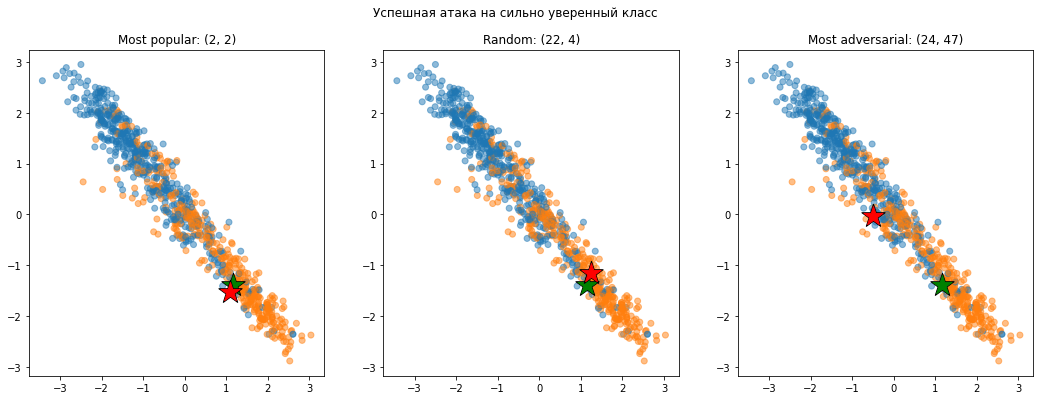

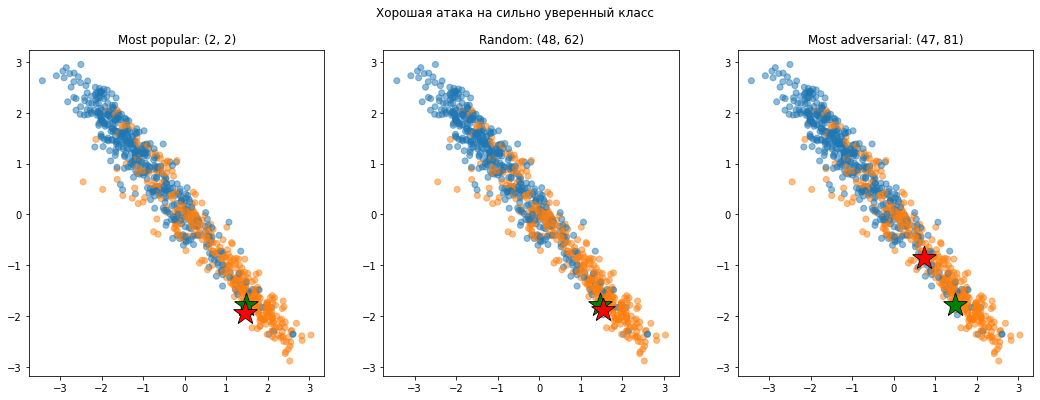

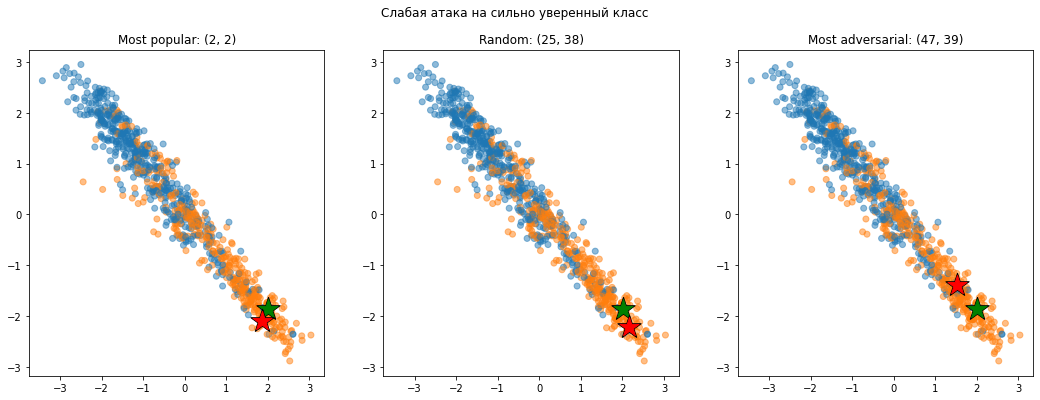

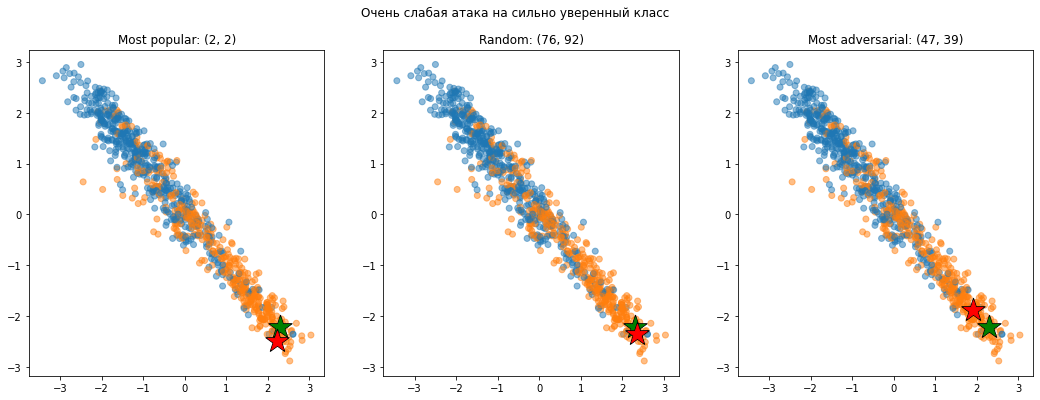

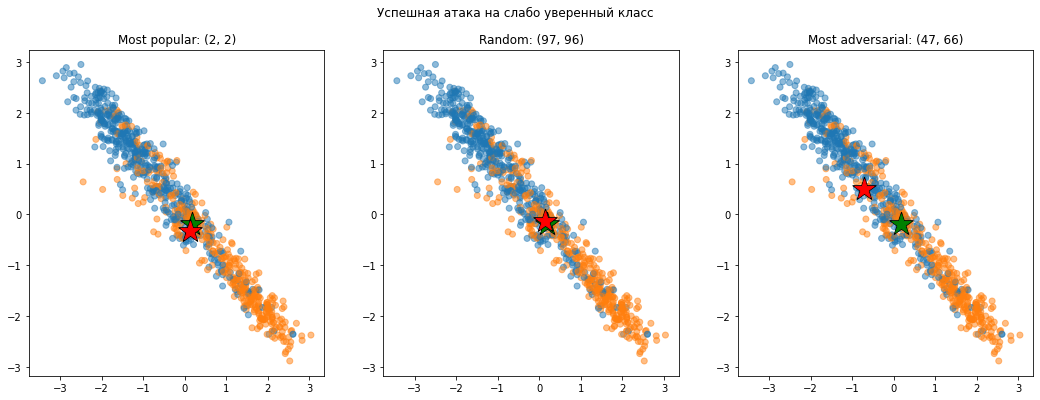

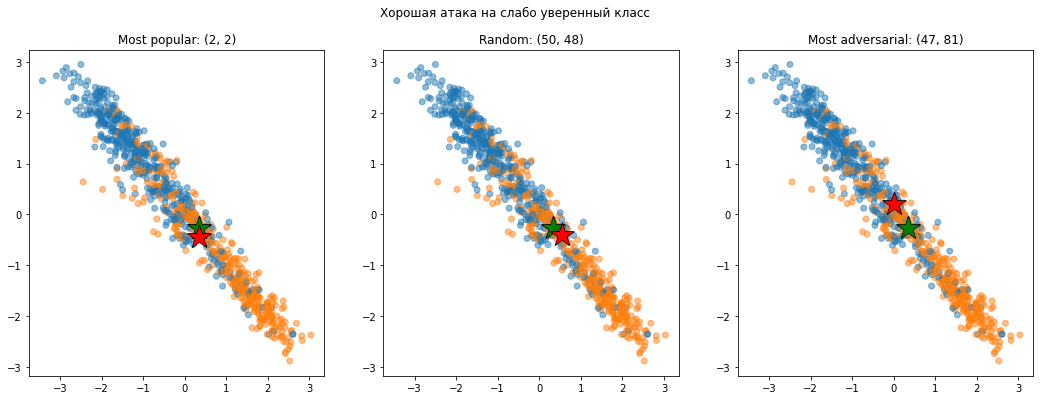

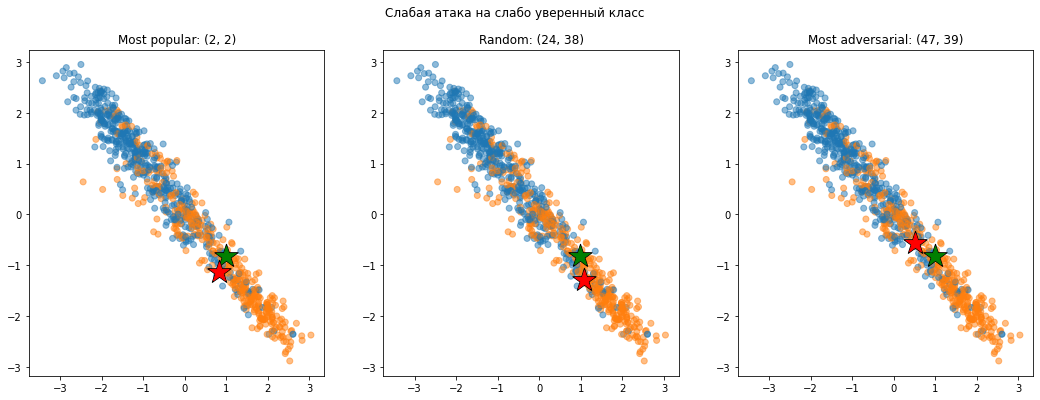

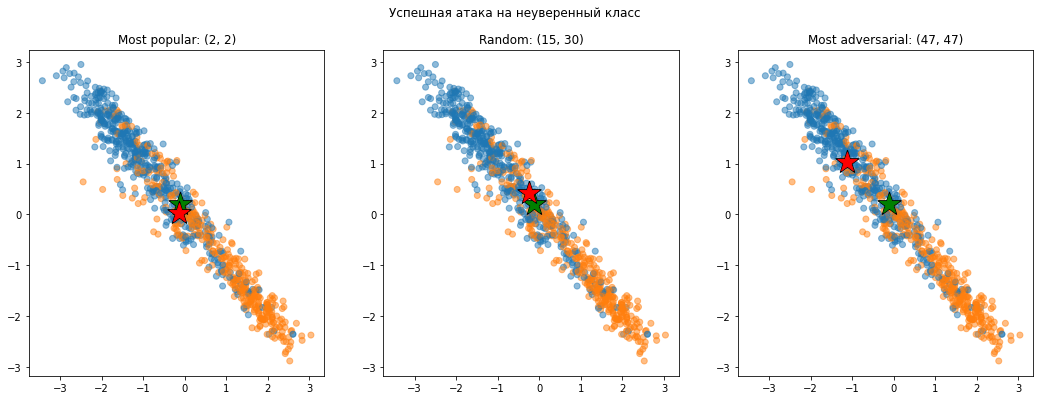

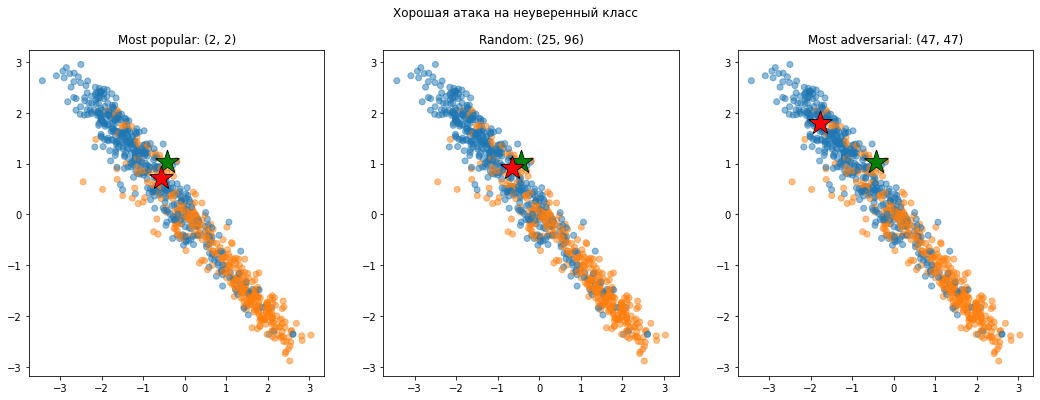

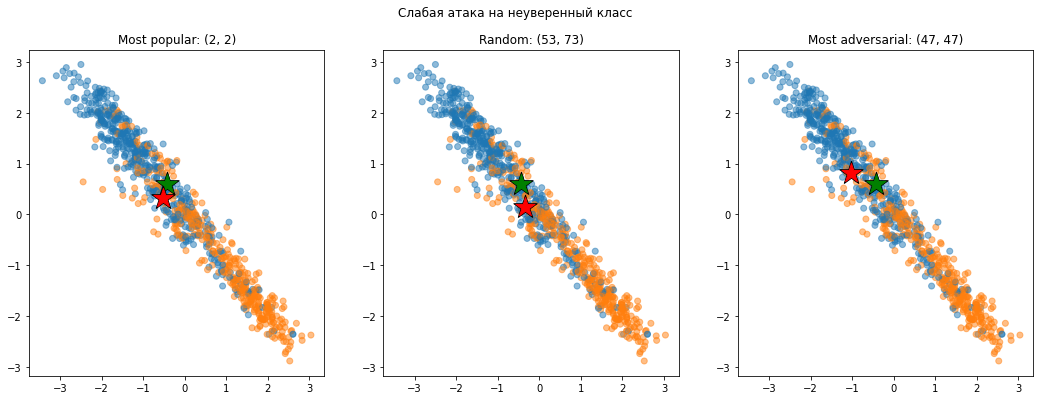

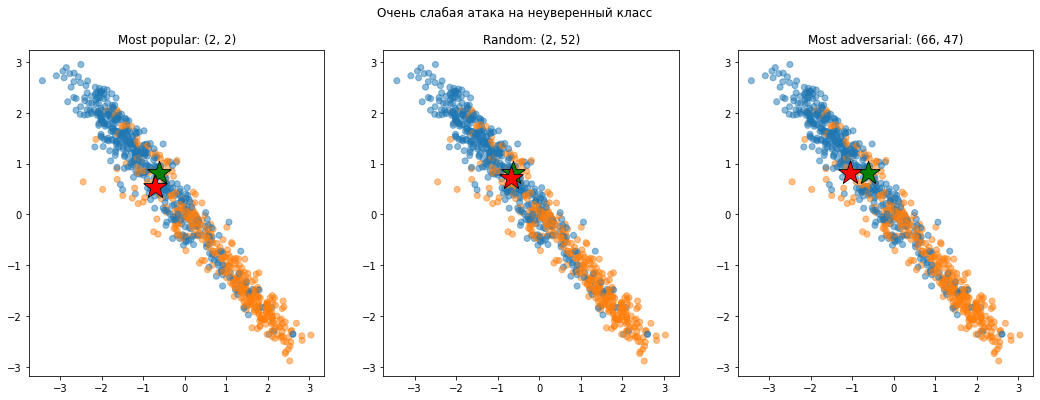

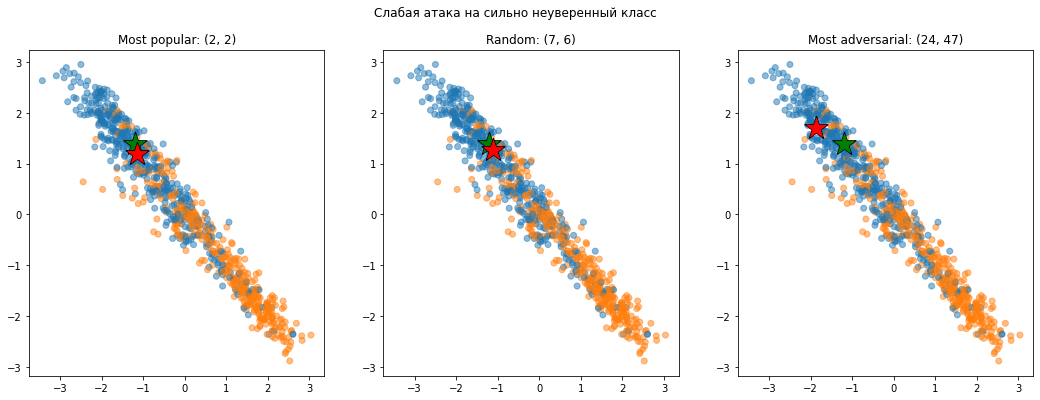

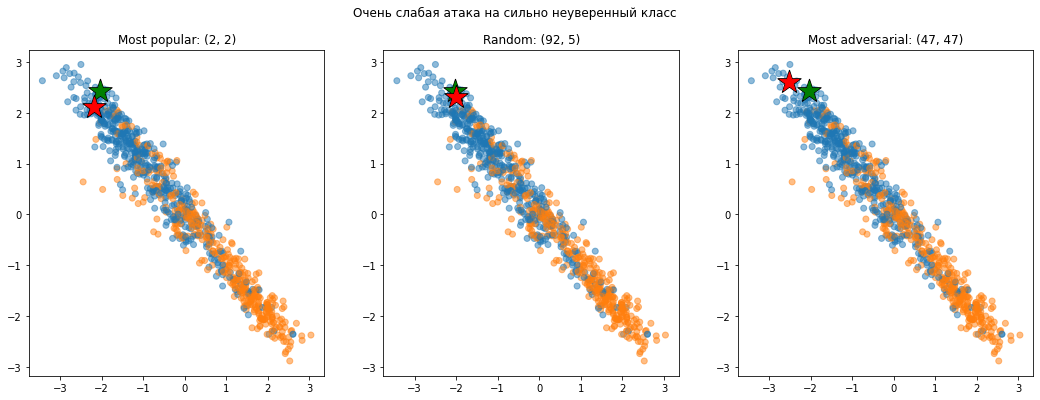

In [478]:
plot_example(132, 'Успешная атака на сильно уверенный класс')
plot_example(660, 'Хорошая атака на сильно уверенный класс')
plot_example(226, 'Слабая атака на сильно уверенный класс')
plot_example(256, 'Очень слабая атака на сильно уверенный класс')

plot_example(801, 'Успешная атака на слабо уверенный класс')
plot_example(379, 'Хорошая атака на слабо уверенный класс')
plot_example(90, 'Слабая атака на слабо уверенный класс')

plot_example(819, 'Успешная атака на неуверенный класс')
plot_example(421, 'Хорошая атака на неуверенный класс')
plot_example(58, 'Слабая атака на неуверенный класс')
plot_example(245, 'Очень слабая атака на неуверенный класс')

plot_example(92, 'Слабая атака на сильно неуверенный класс')
plot_example(29, 'Очень слабая атака на сильно неуверенный класс')


In [485]:
for trx in attack_dm.test_dataloader().dataset:
    print(trx)
    if trx[1]['new_mcc'] is not None:
        continue
    break

({'amount': tensor([ -9.0057, -12.1942,  -9.3656,  -8.4349, -10.6873, -10.2224,  -9.6628,
         -8.4102,  -7.1198, -11.5090,  -8.7937,  -7.5442,  -9.5948,  -8.4825,
         -8.4052, -11.8600,  11.8600,  -8.1226,  -8.4067,  -8.3082,  -9.0512,
         -9.7451, -10.5848,  -9.2856, -10.0931,  -9.4175, -10.7101,  10.0683,
        -12.3220,  11.8112,  -9.2210,   7.7173,  -9.1038,  -8.8170,  11.6289,
         -9.2069,  -8.7855,  -8.1058,  -8.6883,  -9.3903,  -8.6119,  -9.3264,
         -8.6639, -11.1181,  -9.3264,  12.5127,  -9.2210,  12.5044,  -7.7173,
         -9.6628,  -8.2234,  -8.8113, -10.7988,  -9.2321,  -9.1521,  -9.2654,
         -9.5792,  -9.0059, -10.0195,  -9.4162, -10.2819,  13.6331,  11.8277,
         11.7059,  -8.4062, -12.3708,  11.9654, -11.0842,  12.7473,  -9.9141,
         -9.5670, -10.0195, -10.5670,  -8.5664,  -9.7922,  11.8277,  -9.6914,
         -9.2985,  -9.3264,  -7.2068,  -9.0064, -10.0983,  -9.5383,  -9.1686,
         -8.5160,  10.4249, -10.4249,   9.9141,  11.

# Export

In [494]:
import jsonlines

In [514]:
%%time
with jsonlines.open('original_scores.jsonl', 'w') as f:
    for rec in df_test_orig[['id', 't_score_orig', 't_x_orig', 't_y_orig', 'y']] \
        .assign(t_score_orig=lambda x: np.round(x['t_score_orig'], 3)) \
        .assign(t_x_orig=lambda x: np.round(x['t_x_orig'], 2)) \
        .assign(t_y_orig=lambda x: np.round(x['t_y_orig'], 2)) \
        .to_dict(orient='records'):
        f.write(rec)

CPU times: user 13.6 ms, sys: 224 µs, total: 13.9 ms
Wall time: 12.5 ms


In [515]:
!wc -l original_scores.jsonl
!ls -lh original_scores.jsonl
!head -n 3 original_scores.jsonl

840 original_scores.jsonl
-rw-r--r-- 1 ivan sudo 66K Jun  3 12:20 original_scores.jsonl
{"id": 0, "t_score_orig": 0.018, "t_x_orig": -2.82, "t_y_orig": 2.22, "y": 0}
{"id": 1, "t_score_orig": 0.762, "t_x_orig": 0.72, "t_y_orig": -0.9, "y": 0}
{"id": 2, "t_score_orig": 0.632, "t_x_orig": 0.57, "t_y_orig": -0.3, "y": 1}


In [503]:
selected_ids = [
    132, 660, 226, 256, 801, 379, 90, 819, 421, 58, 245, 92, 29,  # selected by t_score_orig_bin, t_p_drop_bin
]

In [516]:
%%time
with jsonlines.open('selected_trx.jsonl', 'w') as f:
    for trx in attack_dm.test_dataloader().dataset:
        if trx[1]['new_mcc'] is not None:
            continue
        if trx[1]['id'] not in selected_ids:
            continue
    
        rec = trx[1]
        rec['trx'] = {k: v.numpy() for k, v in trx[0].items()}
        rec['trx']['amount'] = np.round(rec['trx']['amount'], 2)
        rec['trx']['event_time'] = np.round(rec['trx']['event_time'], 2)
        rec['trx'] = {k: v.tolist() for k, v in rec['trx'].items()}
        
        f.write(rec)

CPU times: user 1min 56s, sys: 552 ms, total: 1min 57s
Wall time: 1min 57s


In [517]:
!wc -l selected_trx.jsonl
!ls -lh selected_trx.jsonl
!head -n 2 selected_trx.jsonl

13 selected_trx.jsonl
-rw-r--r-- 1 ivan sudo 109K Jun  3 12:27 selected_trx.jsonl
{"id": 29, "y": 1, "new_mcc": null, "new_mcc_len": 0, "trx": {"amount": [-9.33, -8.69, -9.21, -10.26, -6.87, -9.72, -9.33, -7.27, -9.56, -8.06, -9.14, -6.11, -11.05, -8.85, -8.68, -8.68, -9.13, -7.43, 11.65, -9.81, -9.36, -5.42, -5.42, -5.42, -7.72, -7.59, -8.54, -7.92, -10.02, -7.55, -8.77, -8.41, -8.59, -7.92, -6.01, -7.72, -6.29, -7.39, -7.27, -9.17, -8.48, -7.72, -7.38, -9.91, -9.14, -8.08, -7.57, -6.33, -7.26, -7.59, -8.12, -7.98, -7.89, -7.2, -9.91, -7.19, -7.94, -8.54, -8.54, -7.9, -6.11, -8.82, -9.25, -7.65, -8.02, -9.91, -11.27, -9.32, -8.41, -5.42, -6.11, -7.93, -9.93, -7.72, -10.6, -9.91, -9.1, -8.09, -7.63, -10.66, -9.1, -8.55, -9.41, -8.89, -8.37, -7.72, -7.02, -8.86, -10.94, -8.73, -9.1, -10.02, -8.62, -7.17, -10.36, -7.41, -8.54, -6.11, -8.57, -7.5, -8.63, -9.91, -7.72, -9.14, -9.16, -8.82, -8.41, -8.5, -7.72, 6.51, -8.71, -7.72, -7.54, -9.8, -7.72, -9.15, -10.29, -8.55, -8.63, -6.5, -8.6, 

In [522]:
%%time
with jsonlines.open('selected_attacks.jsonl', 'w') as f:
    for rec in df_test[lambda x: x['id'].isin(selected_ids)].round(3).to_dict(orient='records'):
        f.write(rec)

CPU times: user 2.55 s, sys: 103 ms, total: 2.65 s
Wall time: 2.65 s


In [523]:
!wc -l selected_attacks.jsonl
!ls -lh selected_attacks.jsonl
!head -n 2 selected_attacks.jsonl

126126 selected_attacks.jsonl
-rw-r--r-- 1 ivan sudo 30M Jun  3 12:33 selected_attacks.jsonl
{"id": 29, "y": 1, "new_mcc": [2], "new_mcc_len": 1, "t_x": -2.192, "t_y": 2.208, "t_score": 0.028, "s_score": 0.02, "s_score_orig": 0.02, "t_score_orig": 0.026, "t_x_orig": -2.035, "t_y_orig": 2.427, "s_p_drop": -0.0, "t_p_drop": -0.002}
{"id": 29, "y": 1, "new_mcc": [3], "new_mcc_len": 1, "t_x": -1.893, "t_y": 2.257, "t_score": 0.033, "s_score": 0.017, "s_score_orig": 0.02, "t_score_orig": 0.026, "t_x_orig": -2.035, "t_y_orig": 2.427, "s_p_drop": 0.003, "t_p_drop": -0.007}
